# SDV Models: Comprehensive Evaluation - AD Dataset

This notebook contains a comprehensive evaluation of four synthetic data generation models on the Alzheimer's Disease (AD) dataset:
1. **CopulaGAN** - GAN-based with copula modeling
2. **Gaussian Copula** - Statistical copula-based approach
3. **CTGAN** - Conditional Tabular GAN
4. **TVAE** - Tabular Variational Autoencoder

Each model is evaluated using multiple fidelity metrics including KS test, JS divergence, Wasserstein distance, and more.


## 1. Data Loading and Setup


In [1]:
import pandas as pd
from sdv.metadata import SingleTableMetadata
import warnings
warnings.filterwarnings('ignore')

# 1. Load the data
ad_data = pd.read_excel('AD data.xlsx')

# 2. Remove columns we don't need
# errors='ignore' means "don't crash if these columns are already gone"
ad_data = ad_data.drop(columns=['Subject ID', 'MRI ID', 'Hand'], errors='ignore')

# 3. Convert text to numbers (Encoding)
# We use .replace() which is easier to read than .map()
ad_data['Group'] = ad_data['Group'].replace({'Demented': 1, 'Nondemented': 2, 'Converted': 3})
ad_data['M/F'] = ad_data['M/F'].replace({'M': 1, 'F': 0})

# 4. Handle missing values (The easy way)
# Fill all missing numbers with the average (mean) automatically
ad_data = ad_data.fillna(ad_data.mean(numeric_only=True))

# If there are still missing values (in text columns), fill them with the most common value
for col in ad_data.columns:
    if ad_data[col].isnull().any():
        ad_data[col] = ad_data[col].fillna(ad_data[col].mode()[0])

# 5. Show the result
print("Data cleaned successfully!")
print(ad_data.head())

# 6. Detect Metadata for SDV
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(ad_data)
print(f"Metadata detected. Columns found: {len(ad_data.columns)}")

Data cleaned successfully!
   Group  Visit  MR Delay  M/F  Age  EDUC       SES  MMSE  CDR         eTIV  \
0      2      1         0    1   87    14  2.000000  27.0  0.0  1986.550000   
1      2      2       457    1   88    14  2.000000  30.0  0.0  2004.479526   
2      1      1         0    1   75    12  2.460452  23.0  0.5  1678.290000   
3      1      2       560    1   76    12  2.460452  28.0  0.5  1737.620000   
4      1      3      1895    1   80    12  2.460452  22.0  0.5  1697.911134   

       nWBV       ASF  
0  0.696106  0.883440  
1  0.681062  0.875539  
2  0.736336  1.045710  
3  0.713402  1.010000  
4  0.701236  1.033623  
Metadata detected. Columns found: 12


# 2. Generating Synthetic data for Four SDV Models

In [4]:
import warnings
warnings.filterwarnings('ignore')
from sdv.single_table import CTGANSynthesizer, CopulaGANSynthesizer, TVAESynthesizer, GaussianCopulaSynthesizer
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic

models = {
    'CTGAN': CTGANSynthesizer,
    'CopulaGAN': CopulaGANSynthesizer,
    'TVAE': TVAESynthesizer,
    'GaussianCopula': GaussianCopulaSynthesizer
}

synthetic_data = {}
diagnostics = {}
quality_report = {}

for name, Synthesizer in models.items():
    print(f"\nSynthesizing with {name}...")

    model = Synthesizer(metadata)
    model.fit(ad_data)

    synthetic_data[name] = model.sample(2000)

    diagnostics[name] = run_diagnostic(ad_data, synthetic_data[name], metadata)
    quality_report[name] = evaluate_quality(ad_data, synthetic_data[name], metadata)

    print(f'{name} synthetic data generated successfully!')

print("=========================================")
for name in models:
    print(f"Diagnostics for {name}:")
    print(diagnostics[name])
    print("-" * 40)

print("=========================================")
for name in models:
    print(f"Quality report for {name}:")
    print(quality_report[name])
    print("-" * 40)


Synthesizing with CTGAN...
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<?, ?it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 330.86it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 864.64it/s]|
Column Shapes Score: 80.97%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 358.59it/s]|
Column Pair Trends Score: 80.99%

Overall Score (Average): 80.98%

CTGAN synthetic data generated successfully!

Synthesizing with CopulaGAN...
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 528.58it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 249.74it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:

# 3. Utility functions



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_tstr_trtr(
    real_data,
    synthetic_data=None,
    target_col='Group',
    model_classes=None,
    model_params=None,
    test_size=0.2,
    random_state=42,
    name='Model'
):
    """
    Evaluate TRTR (Train Real, Test Real) and TSTR (Train Synthetic, Test Real)
    for multiple classifiers.

    Returns:
        results[model_name] = {
            "TRTR": {accuracy, f1, precision, recall},
            "TSTR": {accuracy, f1, precision, recall} or None
        }
    """
    if model_classes is None:
        model_classes = [RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier]

    if model_params is None:
        # shared params for all models; override per model if you want later
        model_params = {}

    if target_col not in real_data.columns:
        print(f"[{name}] Target column '{target_col}' not in real_data. Skipping.")
        return {}

    # ------------------------
    # 1. Split REAL data once
    # ------------------------
    X_real = real_data.drop(columns=[target_col])
    y_real = real_data[target_col]

    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        X_real,
        y_real,
        test_size=test_size,
        random_state=random_state,
    )

    results = {}

    for cls in model_classes:
        model_name = cls.__name__

        print(f"\n===== {name} | {model_name} =====")

        # ============ TRTR ============
        scaler_trtr = StandardScaler().fit(X_train_real)
        X_train_real_scaled = scaler_trtr.transform(X_train_real)
        X_test_real_scaled = scaler_trtr.transform(X_test_real)

        model_trtr = cls(random_state=random_state, **model_params)
        model_trtr.fit(X_train_real_scaled, y_train_real)

        y_pred_trtr = model_trtr.predict(X_test_real_scaled)

        acc_trtr = accuracy_score(y_test_real, y_pred_trtr)
        f1_trtr = f1_score(y_test_real, y_pred_trtr, average='weighted')
        prec_trtr = precision_score(y_test_real, y_pred_trtr, average='weighted', zero_division=0)
        rec_trtr = recall_score(y_test_real, y_pred_trtr, average='weighted', zero_division=0)

        print(f"[TRTR] Train on Real, Test on Real")
        print(f"  Accuracy  = {acc_trtr:.3f}")
        print(f"  F1 Score  = {f1_trtr:.3f}")
        print(f"  Precision = {prec_trtr:.3f}")
        print(f"  Recall    = {rec_trtr:.3f}")
        print("-" * 60)

        trtr_results = {
            "accuracy": acc_trtr,
            "f1": f1_trtr,
            "precision": prec_trtr,
            "recall": rec_trtr,
        }

        # ============ TSTR ============
        tstr_results = None

        if synthetic_data is not None:
            if target_col not in synthetic_data.columns:
                print(f"[{name} | {model_name}] Target column '{target_col}' not in synthetic_data. Skipping TSTR.")
            else:
                X_synth = synthetic_data.drop(columns=[target_col])
                y_synth = synthetic_data[target_col]

                X_train_synth, _, y_train_synth, _ = train_test_split(
                    X_synth,
                    y_synth,
                    test_size=test_size,
                    random_state=random_state,
                )

                scaler_tstr = StandardScaler().fit(X_train_synth)
                X_train_synth_scaled = scaler_tstr.transform(X_train_synth)
                X_test_real_scaled_tstr = scaler_tstr.transform(X_test_real)

                model_tstr = cls(random_state=random_state, **model_params)
                model_tstr.fit(X_train_synth_scaled, y_train_synth)

                y_pred_tstr = model_tstr.predict(X_test_real_scaled_tstr)

                acc_tstr = accuracy_score(y_test_real, y_pred_tstr)
                f1_tstr = f1_score(y_test_real, y_pred_tstr, average='weighted')
                prec_tstr = precision_score(y_test_real, y_pred_tstr, average='weighted', zero_division=0)
                rec_tstr = recall_score(y_test_real, y_pred_tstr, average='weighted', zero_division=0)

                print(f"[TSTR] Train on Synthetic, Test on Real")
                print(f"  Accuracy  = {acc_tstr:.3f}")
                print(f"  F1 Score  = {f1_tstr:.3f}")
                print(f"  Precision = {prec_tstr:.3f}")
                print(f"  Recall    = {rec_tstr:.3f}")

                tstr_results = {
                    "accuracy": acc_tstr,
                    "f1": f1_tstr,
                    "precision": prec_tstr,
                    "recall": rec_tstr,
                }

        results[model_name] = {"TRTR": trtr_results, "TSTR": tstr_results}

    return results

In [6]:
# Names and synthetic datasets expected in this dictionary:
# synthetic_data = {
#     "CTGAN": synthetic_data_ctgan,
#     "CopulaGAN": synthetic_data_copulagan,
#     "TVAE": synthetic_data_tvae,
#     "GaussianCopula": synthetic_data_gaussian
# }

tstr_trtr_results = {}

for name, synth_df in synthetic_data.items():
    print(f"\nRunning TSTR/TRTR for {name}...")
    
    results = evaluate_tstr_trtr(
        real_data=ad_data,
        synthetic_data=synth_df,
        target_col='Group',
        name=name
    )
    
    tstr_trtr_results[name] = results

print("\n==============================")
print("All TSTR/TRTR evaluations complete.")
print("==============================")



Running TSTR/TRTR for CTGAN...

===== CTGAN | RandomForestClassifier =====
[TRTR] Train on Real, Test on Real
  Accuracy  = 0.853
  F1 Score  = 0.821
  Precision = 0.835
  Recall    = 0.853
------------------------------------------------------------
[TSTR] Train on Synthetic, Test on Real
  Accuracy  = 0.440
  F1 Score  = 0.394
  Precision = 0.369
  Recall    = 0.440

===== CTGAN | GradientBoostingClassifier =====
[TRTR] Train on Real, Test on Real
  Accuracy  = 0.880
  F1 Score  = 0.854
  Precision = 0.896
  Recall    = 0.880
------------------------------------------------------------
[TSTR] Train on Synthetic, Test on Real
  Accuracy  = 0.427
  F1 Score  = 0.382
  Precision = 0.358
  Recall    = 0.427

===== CTGAN | AdaBoostClassifier =====
[TRTR] Train on Real, Test on Real
  Accuracy  = 0.773
  F1 Score  = 0.782
  Precision = 0.797
  Recall    = 0.773
------------------------------------------------------------
[TSTR] Train on Synthetic, Test on Real
  Accuracy  = 0.507
  F1 Sco

# 4. Fidelity of Synthetic Data

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 561.16it/s]|
Column Shapes Score: 80.97%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 246.08it/s]|
Column Pair Trends Score: 80.99%

Overall Score (Average): 80.98%



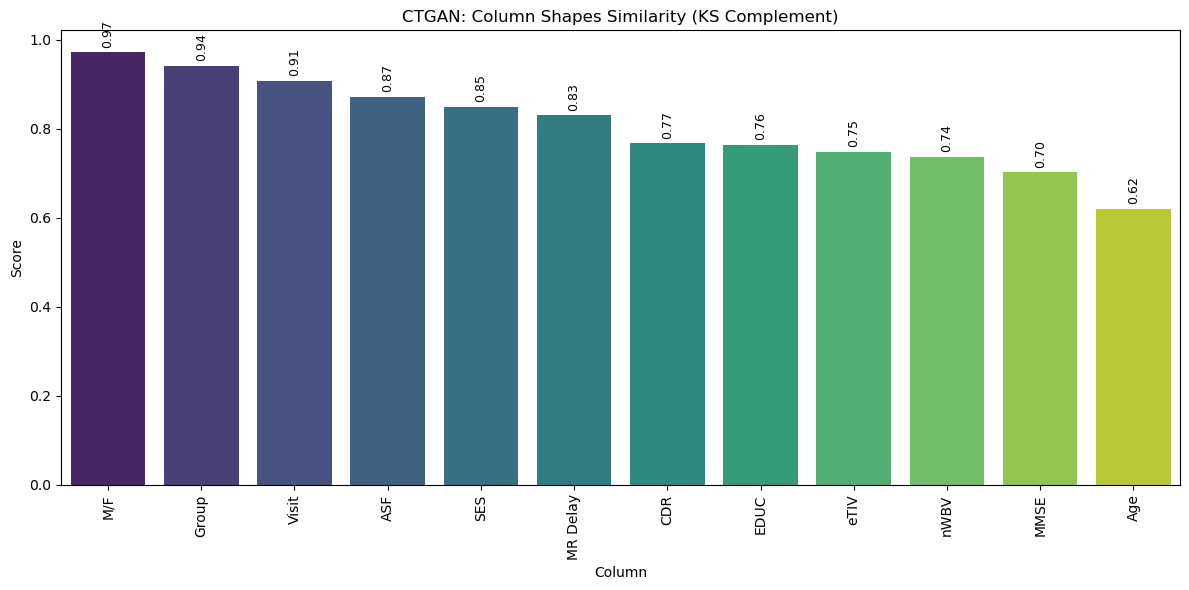

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 464.01it/s]|
Column Shapes Score: 78.68%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 397.60it/s]|
Column Pair Trends Score: 78.43%

Overall Score (Average): 78.55%



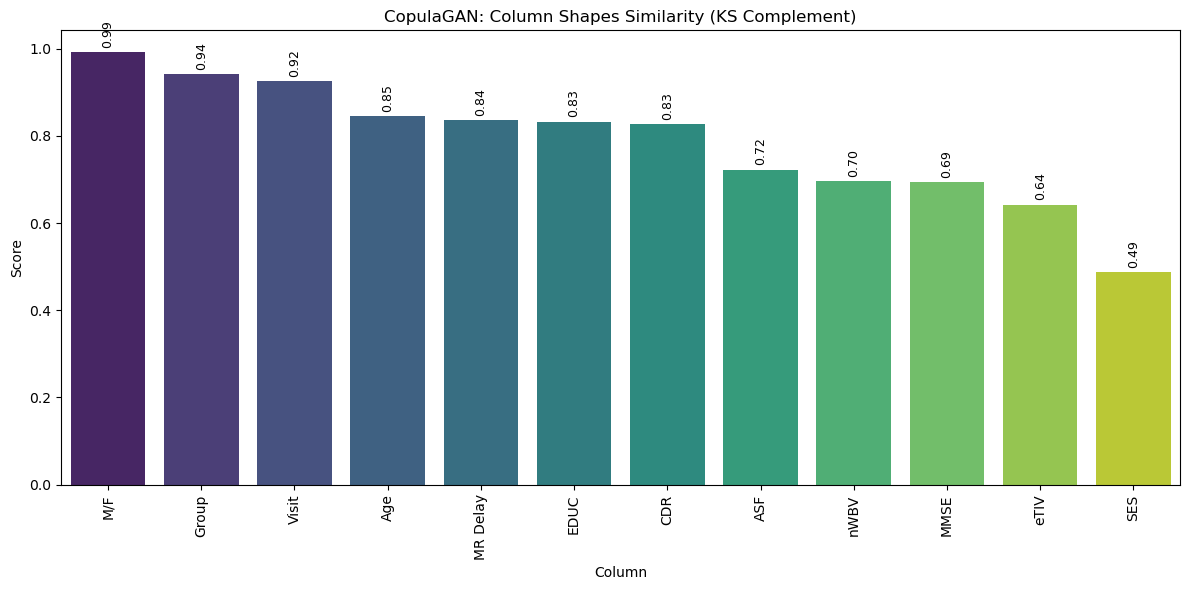

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 563.45it/s]|
Column Shapes Score: 83.6%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 327.83it/s]|
Column Pair Trends Score: 79.72%

Overall Score (Average): 81.66%



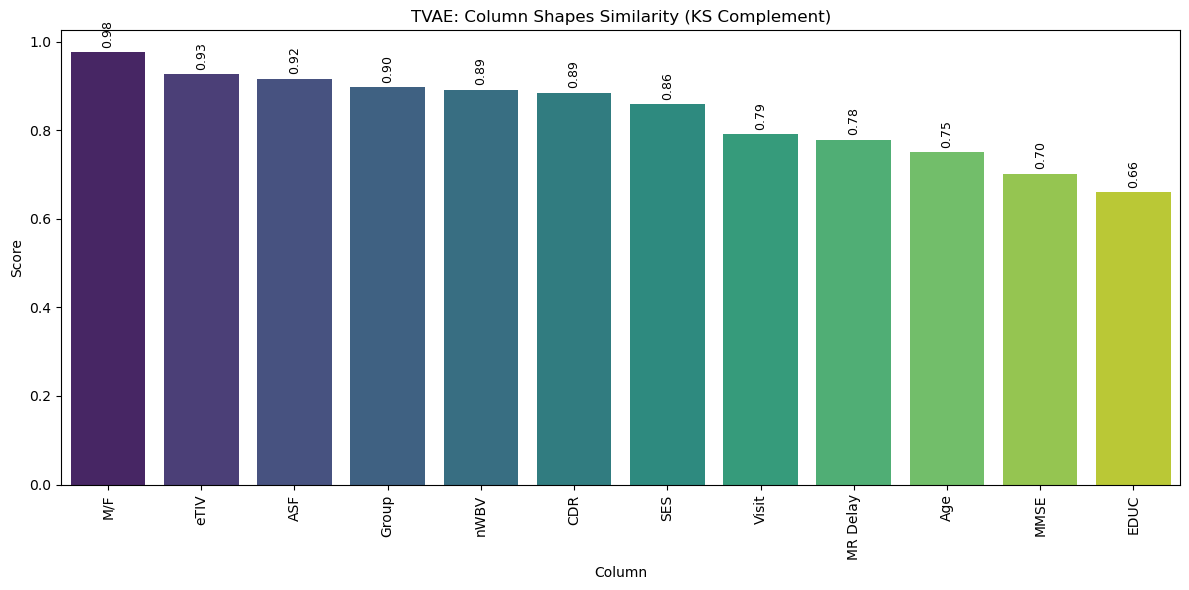

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 519.87it/s]|
Column Shapes Score: 82.7%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 350.03it/s]|
Column Pair Trends Score: 86.48%

Overall Score (Average): 84.59%



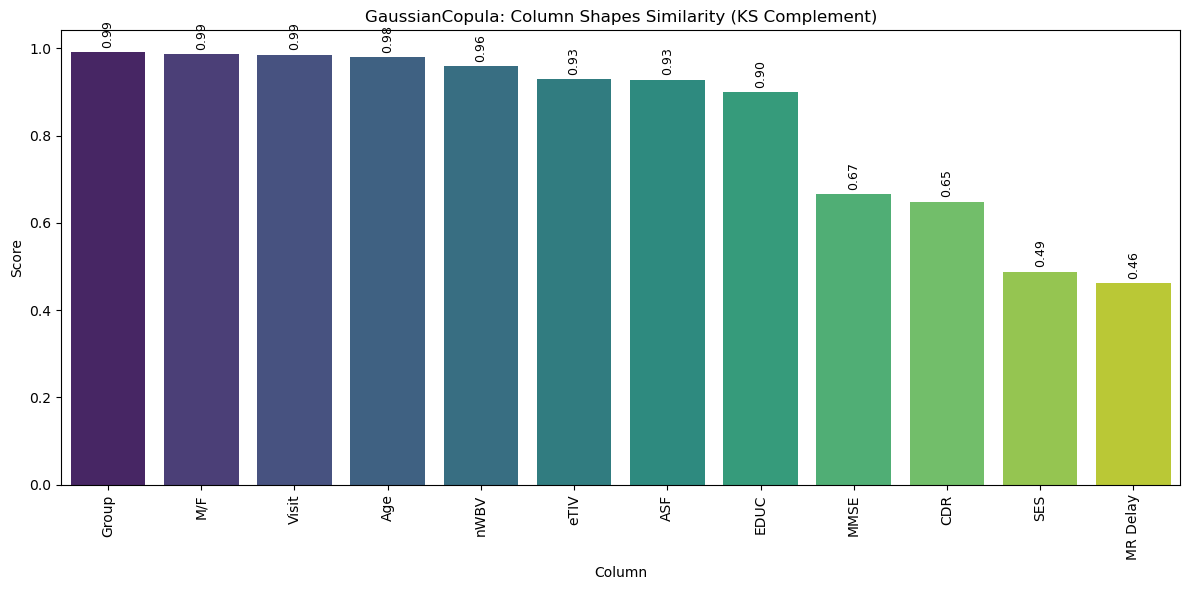

In [8]:
# KS metrics

from sdv.evaluation.single_table import QualityReport
import seaborn as sns, matplotlib.pyplot as plt 

synthetic_data_dict = {
    "CTGAN": synthetic_data["CTGAN"],
    "CopulaGAN": synthetic_data["CopulaGAN"],
    "TVAE": synthetic_data["TVAE"],
    "GaussianCopula": synthetic_data["GaussianCopula"]
}

for model_name, synth_df in synthetic_data_dict.items():
    # Create and generate quality report for this model
    qr = QualityReport()
    qr.generate(
        real_data=ad_data,
        synthetic_data=synth_df,
        metadata=metadata.to_dict()
    )
    
    # Get KS-complement style column shape scores
    details = qr.get_details('Column Shapes')

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='Column',
        y='Score',
        data=details.sort_values('Score', ascending=False),
        palette='viridis'
    )
    
    # Add numbers on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,   # X coordinate: center of bar
            height + 0.01,                   # Y coordinate slightly above bar
            f"{height:.2f}",                 # Format to 2 decimals
            ha='center', va='bottom', fontsize=9, rotation=90
        )

    plt.title(f'{model_name}: Column Shapes Similarity (KS Complement)')
    plt.xticks(rotation=90)
    plt.xlabel('Column')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

In [14]:
# Wasserstein distance 

import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler

# Identify numeric columns only
numeric_cols = ad_data.select_dtypes(include=[np.number]).columns

wasserstein_results = {}  # store per-model results

for model_name, synth_df in synthetic_data_dict.items():

    # --- Standard scaling using REAL data stats ---
    scaler = StandardScaler().fit(ad_data[numeric_cols])

    real_scaled = pd.DataFrame(
        scaler.transform(ad_data[numeric_cols]),
        columns=numeric_cols
    )
    synth_scaled = pd.DataFrame(
        scaler.transform(synth_df[numeric_cols]),
        columns=numeric_cols
    )

    # --- Compute Wasserstein per numeric column ---
    wasserstein_scores = []
    for col in numeric_cols:
        r = real_scaled[col].dropna().astype(float)
        s = synth_scaled[col].dropna().astype(float)

        try:
            w_dist = wasserstein_distance(r, s)
        except Exception:
            w_dist = np.nan

        wasserstein_scores.append({"Column": col, "Wasserstein": w_dist})

    results_df = pd.DataFrame(wasserstein_scores).sort_values("Wasserstein")

    # store per model
    wasserstein_results[model_name] = results_df

    # optional: print for each generator
    print(f"\nWasserstein distances for {model_name}:")
    print(results_df)



Wasserstein distances for CTGAN:
      Column  Wasserstein
3        M/F     0.054646
0      Group     0.091716
6        SES     0.186739
2   MR Delay     0.222253
7       MMSE     0.266534
11       ASF     0.268405
1      Visit     0.270140
8        CDR     0.301473
5       EDUC     0.348878
9       eTIV     0.516021
10      nWBV     0.631805
4        Age     0.905605

Wasserstein distances for CopulaGAN:
      Column  Wasserstein
3        M/F     0.015062
0      Group     0.117387
7       MMSE     0.192843
1      Visit     0.233248
5       EDUC     0.299021
2   MR Delay     0.353093
4        Age     0.361018
8        CDR     0.368894
6        SES     0.489454
10      nWBV     0.620122
11       ASF     0.662566
9       eTIV     0.797917

Wasserstein distances for TVAE:
      Column  Wasserstein
3        M/F     0.047390
6        SES     0.085059
9       eTIV     0.127347
11       ASF     0.132110
0      Group     0.162773
10      nWBV     0.168380
2   MR Delay     0.223195
8        CD

In [ ]:
# JS divergence 

import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler

def compute_js_divergence(real_vals, synth_vals, bins=30):
    """
    Compute JS divergence between two numeric sample sets using histogram estimation.
    Returns divergence (not distance).
    """
    real_vals = np.asarray(real_vals)
    synth_vals = np.asarray(synth_vals)

    # Remove NaN
    real_vals = real_vals[~np.isnan(real_vals)]
    synth_vals = synth_vals[~np.isnan(synth_vals)]

    if len(real_vals) == 0 or len(synth_vals) == 0:
        return np.nan

    # Shared histogram bins
    low = min(real_vals.min(), synth_vals.min())
    high = max(real_vals.max(), synth_vals.max())
    if low == high:
        return 0.0  # identical column

    p_hist, bin_edges = np.histogram(real_vals, bins=bins, range=(low, high), density=True)
    q_hist, _ = np.histogram(synth_vals, bins=bin_edges, density=True)

    # Add epsilon to avoid zeros
    p = p_hist + 1e-12
    q = q_hist + 1e-12
    p /= p.sum()
    q /= q.sum()

    js_distance = jensenshannon(p, q, base=2)   # distance
    js_div = js_distance ** 2                   # divergence
    return js_div


# ==========================
# JS Divergence Loop
# ==========================

js_results = {}
numeric_cols = ad_data.select_dtypes(include=[np.number]).columns

for model_name, synth_df in synthetic_data_dict.items():

    # Standardize using REAL data stats
    scaler = StandardScaler().fit(ad_data[numeric_cols])
    real_scaled = pd.DataFrame(scaler.transform(ad_data[numeric_cols]), columns=numeric_cols)
    synth_scaled = pd.DataFrame(scaler.transform(synth_df[numeric_cols]), columns=numeric_cols)

    # Compute JS divergence per column
    js_scores = []
    for col in numeric_cols:
        r = real_scaled[col].dropna().astype(float)
        s = synth_scaled[col].dropna().astype(float)

        try:
            jsd = compute_js_divergence(r, s)
        except Exception:
            jsd = np.nan

        js_scores.append({"Column": col, "JS_Divergence": jsd})

    results_df = pd.DataFrame(js_scores).sort_values("JS_Divergence")

    js_results[model_name] = results_df

    # Optional print
    print(f"\nJS Divergence for {model_name}:")
    print(results_df)



JS Divergence for CTGAN:
      Column  JS_Divergence
3        M/F       0.000535
0      Group       0.004470
1      Visit       0.012527
11       ASF       0.050914
7       MMSE       0.069958
9       eTIV       0.084058
10      nWBV       0.092527
2   MR Delay       0.111159
4        Age       0.158713
8        CDR       0.195553
5       EDUC       0.229457
6        SES       0.509342

JS Divergence for CopulaGAN:
      Column  JS_Divergence
3        M/F       0.000041
0      Group       0.005593
1      Visit       0.013186
4        Age       0.061548
7       MMSE       0.101693
11       ASF       0.102528
2   MR Delay       0.118580
10      nWBV       0.121234
9       eTIV       0.156488
5       EDUC       0.208912
8        CDR       0.311454
6        SES       0.484227

JS Divergence for TVAE:
      Column  JS_Divergence
3        M/F       0.000408
10      nWBV       0.022739
11       ASF       0.035848
9       eTIV       0.040118
0      Group       0.053062
8        CDR       0.05

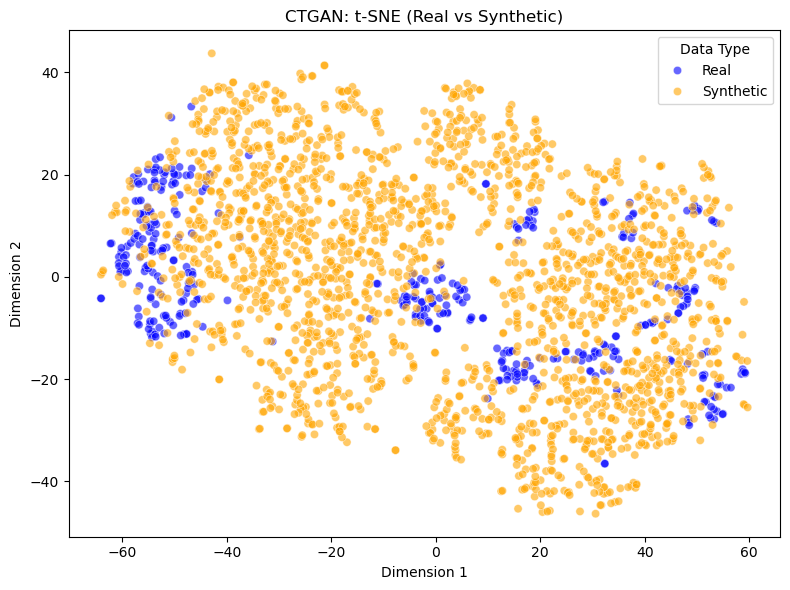

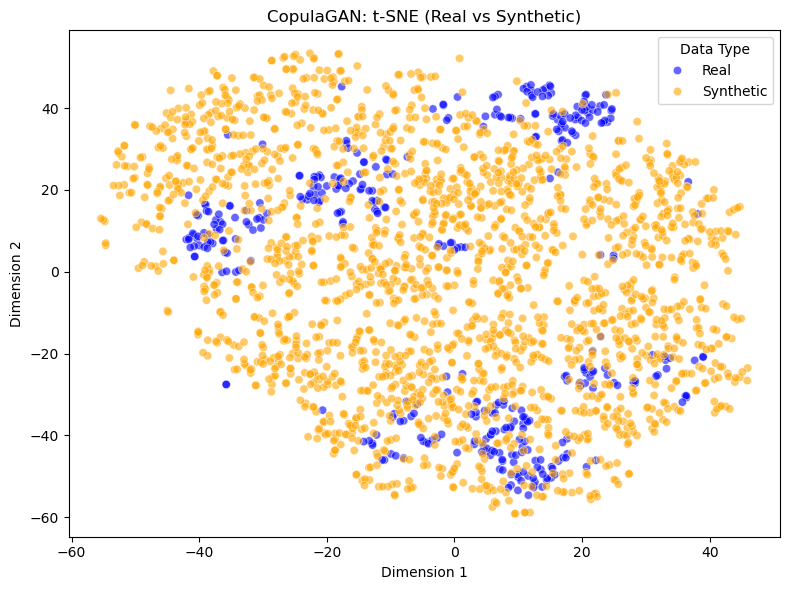

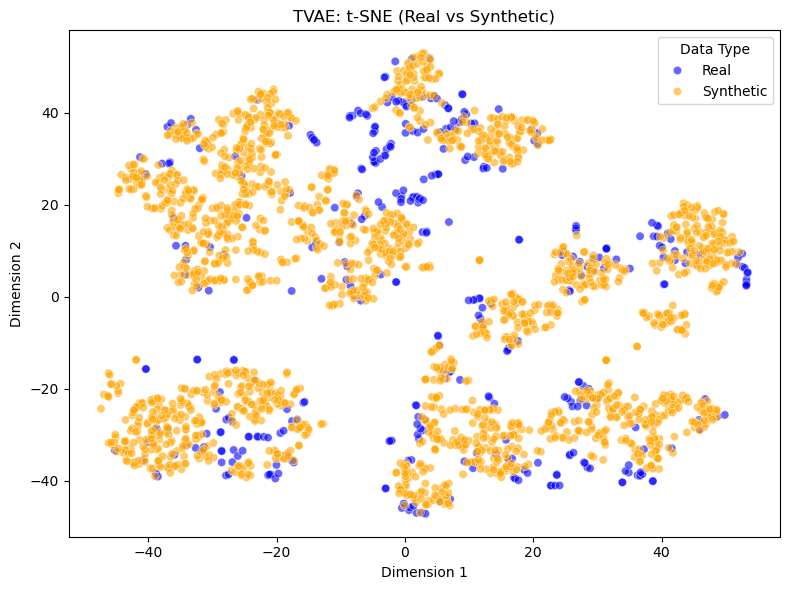

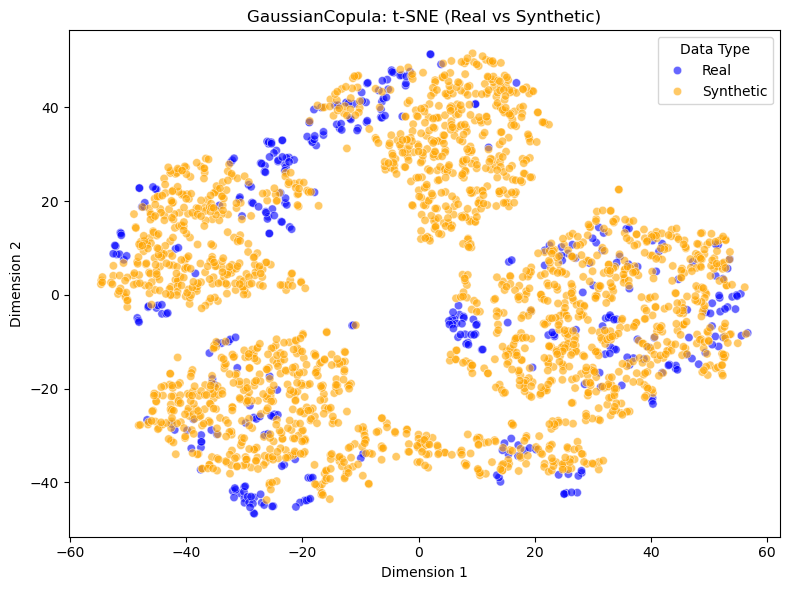

In [ ]:
# t-SNE Visualization

from sklearn.manifold import TSNE

# dict of synthetic datasets you already built
synthetic_data_dict = {
    "CTGAN": synthetic_data["CTGAN"],
    "CopulaGAN": synthetic_data["CopulaGAN"],
    "TVAE": synthetic_data["TVAE"],
    "GaussianCopula": synthetic_data["GaussianCopula"]
}

numeric_cols = ad_data.select_dtypes(include=[np.number]).columns

for model_name, synth_df in synthetic_data_dict.items():
    # 1) Standard scale real + synthetic together (same scaler)
    scaler = StandardScaler().fit(ad_data[numeric_cols])
    real_scaled = pd.DataFrame(
        scaler.transform(ad_data[numeric_cols]),
        columns=numeric_cols
    )
    synth_scaled = pd.DataFrame(
        scaler.transform(synth_df[numeric_cols]),
        columns=numeric_cols
    )

    # 2) Combine and run t-SNE
    combined = pd.concat(
        [
            real_scaled.assign(Type="Real"),
            synth_scaled.assign(Type="Synthetic")
        ],
        ignore_index=True
    )

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(combined[numeric_cols])

    # 3) Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=combined["Type"],
        palette={"Real": "blue", "Synthetic": "orange"},
        alpha=0.6
    )
    plt.title(f"{model_name}: t-SNE (Real vs Synthetic)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Data Type")
    plt.tight_layout()
    plt.show()

In [18]:
# MMD Function

from sklearn.metrics.pairwise import rbf_kernel

def get_mmd_score(real_df, synth_df, target_col='Group', gamma=1.0):
    """Compute MMD (RBF Kernel) between real and synthetic data."""
    
    # Drop target column if present
    if target_col in real_df.columns:
        real = real_df.drop(columns=[target_col])
        synth = synth_df.drop(columns=[target_col])
    else:
        real = real_df.copy()
        synth = synth_df.copy()

    # Standard scaling
    scaler = StandardScaler()
    r_scaled = scaler.fit_transform(real)
    s_scaled = scaler.transform(synth)

    # Kernel similarities
    k_xx = rbf_kernel(r_scaled, r_scaled, gamma=gamma).mean()
    k_yy = rbf_kernel(s_scaled, s_scaled, gamma=gamma).mean()
    k_xy = rbf_kernel(r_scaled, s_scaled, gamma=gamma).mean()

    # MMD formula
    mmd = k_xx + k_yy - 2 * k_xy
    return mmd

mmd_results = {}

for model_name, synth_df in synthetic_data_dict.items():
    mmd_score = get_mmd_score(ad_data, synth_df)
    mmd_results[model_name] = mmd_score
    print(f"{model_name} - MMD Score (Lower is Better): {mmd_score:.4f}")

CTGAN - MMD Score (Lower is Better): 0.0048
CopulaGAN - MMD Score (Lower is Better): 0.0047
TVAE - MMD Score (Lower is Better): 0.0065
GaussianCopula - MMD Score (Lower is Better): 0.0063


In [19]:
# Cosine Similarity Function

from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(real_df, synth_df, target_col='Group'):
    """Compute average and maximum cosine similarity between real and synthetic samples."""
    
    # Drop target column
    if target_col in real_df.columns:
        real = real_df.drop(columns=[target_col])
        synth = synth_df.drop(columns=[target_col])
    else:
        real = real_df.copy()
        synth = synth_df.copy()

    # Standard scale
    scaler = StandardScaler()
    r_scaled = scaler.fit_transform(real)
    s_scaled = scaler.transform(synth)

    # Cosine similarity matrix: shape (real_samples × synth_samples)
    sim_matrix = cosine_similarity(r_scaled, s_scaled)

    # Metrics
    avg_sim = sim_matrix.mean()
    max_sim = sim_matrix.max()

    return avg_sim, max_sim

cosine_results = {}

for model_name, synth_df in synthetic_data_dict.items():
    avg_sim, max_sim = get_cosine_similarity(ad_data, synth_df)

    cosine_results[model_name] = {
        "average_similarity": avg_sim,
        "max_similarity": max_sim
    }

    print("\n=====================================")
    print(f"Cosine Similarity for {model_name}")
    print("=====================================")
    print(f"Average Similarity: {avg_sim:.4f}")
    print(f"Max Similarity:     {max_sim:.4f}  <-- Warning if close to 1.0")


Cosine Similarity for CTGAN
Average Similarity: -0.0029
Max Similarity:     0.9638  <-- Warning if close to 1.0

Cosine Similarity for CopulaGAN
Average Similarity: 0.0020
Max Similarity:     0.9757  <-- Warning if close to 1.0

Cosine Similarity for TVAE
Average Similarity: 0.0114
Max Similarity:     0.9941  <-- Warning if close to 1.0

Cosine Similarity for GaussianCopula
Average Similarity: 0.0141
Max Similarity:     0.9913  <-- Warning if close to 1.0


# 5. Priavacy check 

In [16]:
import gower
import numpy as np

def check_privacy_gower(real_df, synth_df, name=None):
    """Gower-based privacy check: compares real-vs-real similarity to real-vs-synth."""
    # 1. Similarity within real data (baseline)
    real_dist = gower.gower_matrix(real_df)
    real_sim = 1 - real_dist[np.triu_indices_from(real_dist, k=1)].mean()
    
    # 2. Similarity between real and synthetic
    cross_dist = gower.gower_matrix(real_df, synth_df)
    cross_sim = 1 - cross_dist.mean()
    
    prefix = f"[{name}] " if name is not None else ""
    print(f"{prefix}Similarity within Real Data: {real_sim:.4f}")
    print(f"{prefix}Similarity Real vs Synth:    {cross_sim:.4f}")
    
    if cross_sim > real_sim:
        print(f"{prefix}⚠️ WARNING: Synthetic data is too similar to real data! (Possible Overfitting)")
    else:
        print(f"{prefix}✅ PASS: Synthetic data is distinct enough.")
    
    return {"real_sim": real_sim, "cross_sim": cross_sim}

# --------------------------------------------------
# Run for the four models
# --------------------------------------------------

synthetic_data_dict = {
    "CTGAN": synthetic_data["CTGAN"],
    "CopulaGAN": synthetic_data["CopulaGAN"],
    "TVAE": synthetic_data["TVAE"],
    "GaussianCopula": synthetic_data["GaussianCopula"]
}

privacy_results = {}

for model_name, synth_df in synthetic_data_dict.items():
    print("\n===================================")
    print(f"Privacy check for {model_name}")
    print("===================================")
    privacy_results[model_name] = check_privacy_gower(ad_data, synth_df, name=model_name)




Privacy check for CTGAN
[CTGAN] Similarity within Real Data: 0.7486
[CTGAN] Similarity Real vs Synth:    0.7322
[CTGAN] ✅ PASS: Synthetic data is distinct enough.

Privacy check for CopulaGAN
[CopulaGAN] Similarity within Real Data: 0.7486
[CopulaGAN] Similarity Real vs Synth:    0.7208
[CopulaGAN] ✅ PASS: Synthetic data is distinct enough.

Privacy check for TVAE
[TVAE] Similarity within Real Data: 0.7486
[TVAE] Similarity Real vs Synth:    0.7598
[TVAE] ⚠️ WARNING: Synthetic data is too similar to real data! (Possible Overfitting)

Privacy check for GaussianCopula
[GaussianCopula] Similarity within Real Data: 0.7486
[GaussianCopula] Similarity Real vs Synth:    0.7596
[GaussianCopula] ⚠️ WARNING: Synthetic data is too similar to real data! (Possible Overfitting)


In [20]:
from sklearn.neighbors import NearestNeighbors

def get_nearest_neighbor_distance(real_df, synth_df, target_col='Group'):
    """Compute average nearest-neighbor distance from synthetic → real."""
    
    # Drop target if exists
    if target_col in real_df.columns:
        real = real_df.drop(columns=[target_col])
        synth = synth_df.drop(columns=[target_col])
    else:
        real = real_df.copy()
        synth = synth_df.copy()

    # Standard scale
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real)
    synth_scaled = scaler.transform(synth)

    # Fit NN on real data
    nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)

    # Compute distances from synthetic → nearest real
    distances, _ = nn.kneighbors(synth_scaled)

    return distances.mean()

nn_results = {}

for model_name, synth_df in synthetic_data_dict.items():
    avg_nn_dist = get_nearest_neighbor_distance(ad_data, synth_df)

    nn_results[model_name] = avg_nn_dist

    print("\n===================================")
    print(f"Nearest-Neighbor Privacy for {model_name}")
    print("===================================")
    print(f"Average NN Distance (Synthetic → Real): {avg_nn_dist:.4f}")


Nearest-Neighbor Privacy for CTGAN
Average NN Distance (Synthetic → Real): 2.6545

Nearest-Neighbor Privacy for CopulaGAN
Average NN Distance (Synthetic → Real): 2.6707

Nearest-Neighbor Privacy for TVAE
Average NN Distance (Synthetic → Real): 1.5038

Nearest-Neighbor Privacy for GaussianCopula
Average NN Distance (Synthetic → Real): 1.6367


# 6. Bivariate analysis  

In [23]:
import pandas as pd
import numpy as np

def bivariate_quality(real_df, synth_df, target='Group'):
    # numeric columns excluding target
    num_cols = [c for c in real_df.select_dtypes(include=[np.number]).columns if c != target]

    # -------- 1) Pairwise correlations between features --------
    real_corr = real_df[num_cols].corr()
    synth_corr = synth_df[num_cols].corr()

    records = []
    for i, col1 in enumerate(num_cols):
        for j, col2 in enumerate(num_cols):
            if j <= i:
                continue  # upper triangle only, no duplicates
            r_corr = real_corr.loc[col1, col2]
            s_corr = synth_corr.loc[col1, col2]
            diff = abs(r_corr - s_corr)
            records.append({
                "var1": col1,
                "var2": col2,
                "real_corr": r_corr,
                "synth_corr": s_corr,
                "abs_diff": diff
            })

    corr_results = pd.DataFrame(records).sort_values("abs_diff", ascending=False)

    # -------- 2) Feature–target correlation differences --------
    # Encode target as numeric (shared mapping)
    all_target_vals = pd.concat([real_df[target], synth_df[target]], ignore_index=True)
    codes, uniques = pd.factorize(all_target_vals)
    n_real = len(real_df)

    real_target_enc = codes[:n_real]
    synth_target_enc = codes[n_real:]

    target_diff_records = []
    for col in num_cols:
        real_feat = real_df[col].values
        synth_feat = synth_df[col].values

        # correlation with encoded target
        if np.std(real_feat) == 0 or np.std(real_target_enc) == 0:
            real_tcorr = 0.0
        else:
            real_tcorr = np.corrcoef(real_feat, real_target_enc)[0, 1]

        if np.std(synth_feat) == 0 or np.std(synth_target_enc) == 0:
            synth_tcorr = 0.0
        else:
            synth_tcorr = np.corrcoef(synth_feat, synth_target_enc)[0, 1]

        diff = abs(real_tcorr - synth_tcorr)
        target_diff_records.append({
            "feature": col,
            "real_target_corr": real_tcorr,
            "synth_target_corr": synth_tcorr,
            "abs_diff": diff
        })

    target_results = pd.DataFrame(target_diff_records).sort_values("abs_diff", ascending=False)

    return corr_results, target_results

In [24]:
# Real AD dataset
real_df_ad = ad_data

# Dict of synthetic AD datasets
synthetic_ad_dict = {
    "CTGAN": synthetic_data["CTGAN"],
    "CopulaGAN": synthetic_data["CopulaGAN"],
    "TVAE": synthetic_data["TVAE"],
    "GaussianCopula": synthetic_data["GaussianCopula"]
}

# Storage for results
corr_results_ad_all = {}
target_results_ad_all = {}

for model_name, synth_df in synthetic_ad_dict.items():
    # Align columns with real data
    synth_aligned = synth_df[real_df_ad.columns]

    # Run bivariate quality function
    corr_res, target_res = bivariate_quality(
        real_df=real_df_ad,
        synth_df=synth_aligned,
        target='Group'
    )

    # Store
    corr_results_ad_all[model_name] = corr_res
    target_results_ad_all[model_name] = target_res

    # Print top 10 for each model
    print(f"\n{model_name} - Largest differences in pairwise correlations (AD data):")
    print(corr_res.head(10))
    print("================================")
    print(f"{model_name} - Features that differ most by target class (AD data):")
    print(target_res.head(10))


CTGAN - Largest differences in pairwise correlations (AD data):
     var1      var2  real_corr  synth_corr  abs_diff
53   eTIV       ASF  -0.988868   -0.021455  0.967413
0   Visit  MR Delay   0.920009    0.029317  0.890692
34   EDUC       SES  -0.708680   -0.010688  0.697991
45   MMSE       CDR  -0.679837   -0.022752  0.657085
26    M/F       ASF  -0.561648   -0.016795  0.544853
32    Age      nWBV  -0.518546   -0.018075  0.500471
24    M/F      eTIV   0.572589    0.084784  0.487805
47   MMSE      nWBV   0.341860   -0.036295  0.378155
50    CDR      nWBV  -0.344873   -0.022247  0.322627
42    SES      eTIV  -0.254274    0.043187  0.297461
CTGAN - Features that differ most by target class (AD data):
   feature  real_target_corr  synth_target_corr  abs_diff
7      CDR          0.572518           0.065504  0.507014
6     MMSE         -0.339906          -0.018132  0.321774
9     nWBV         -0.257681           0.015692  0.273373
2      M/F          0.143918          -0.019727  0.163646
4

# 7. Multi Variate analysis

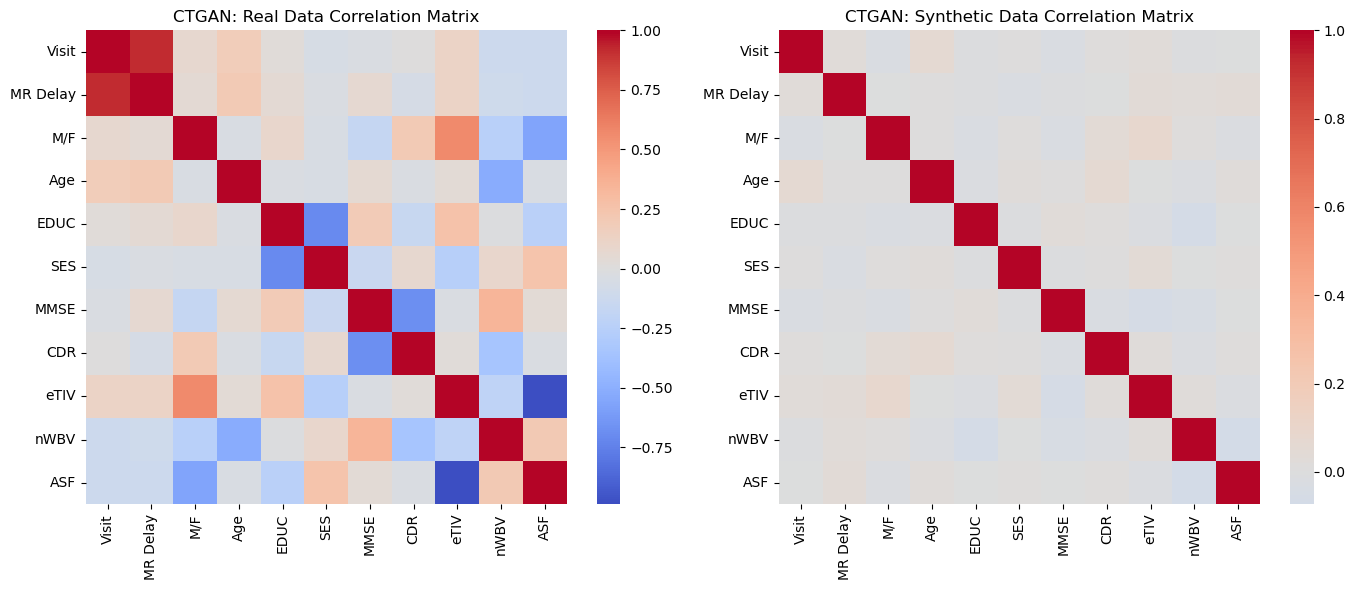

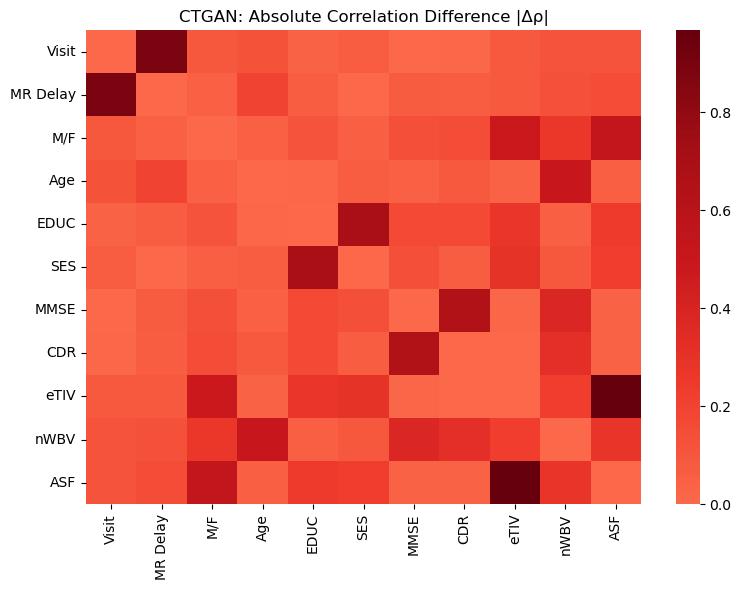

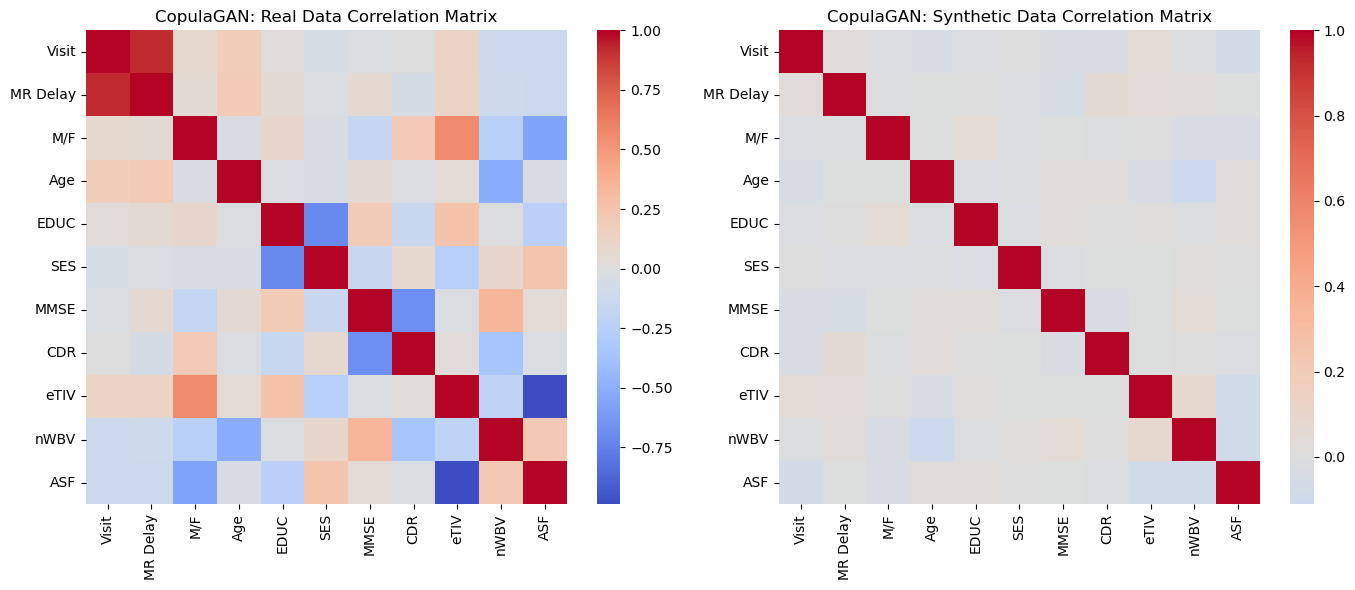

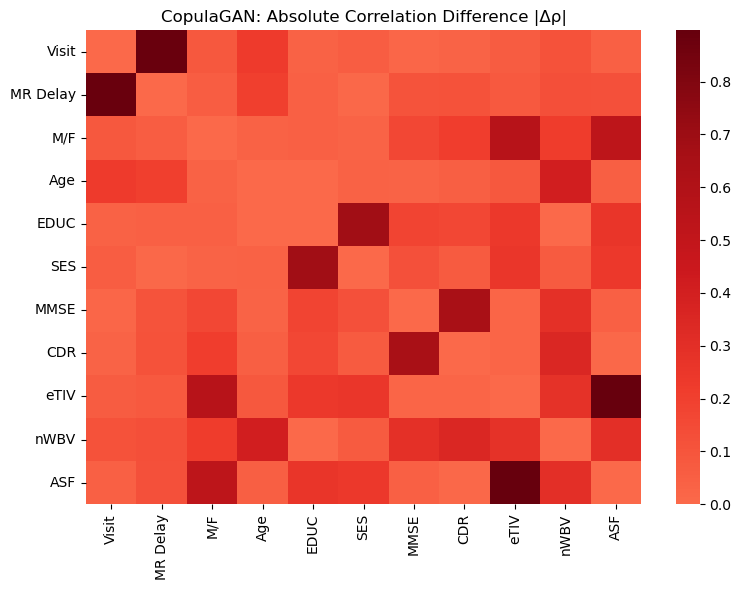

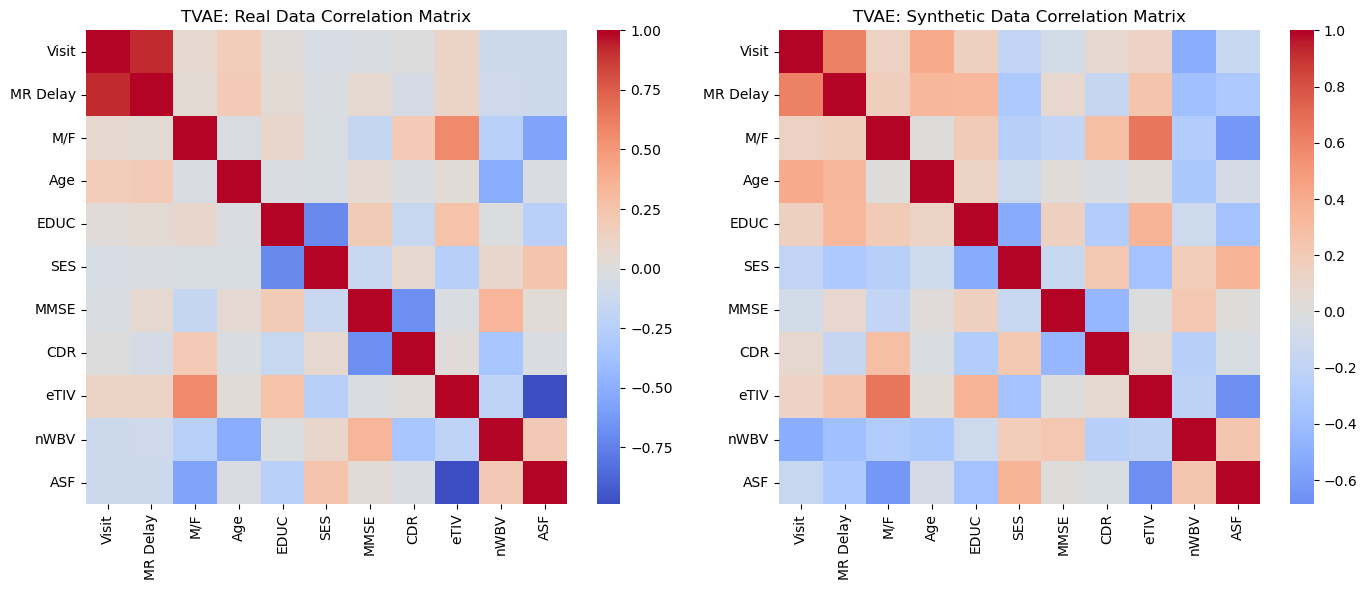

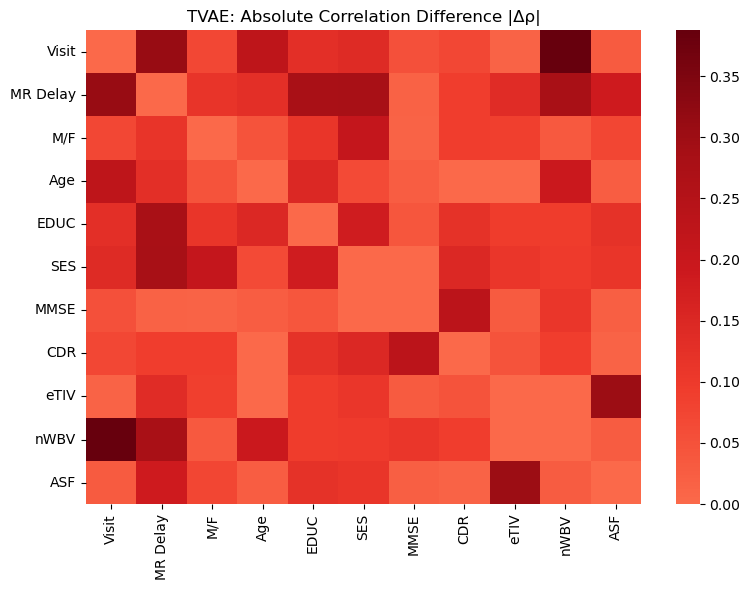

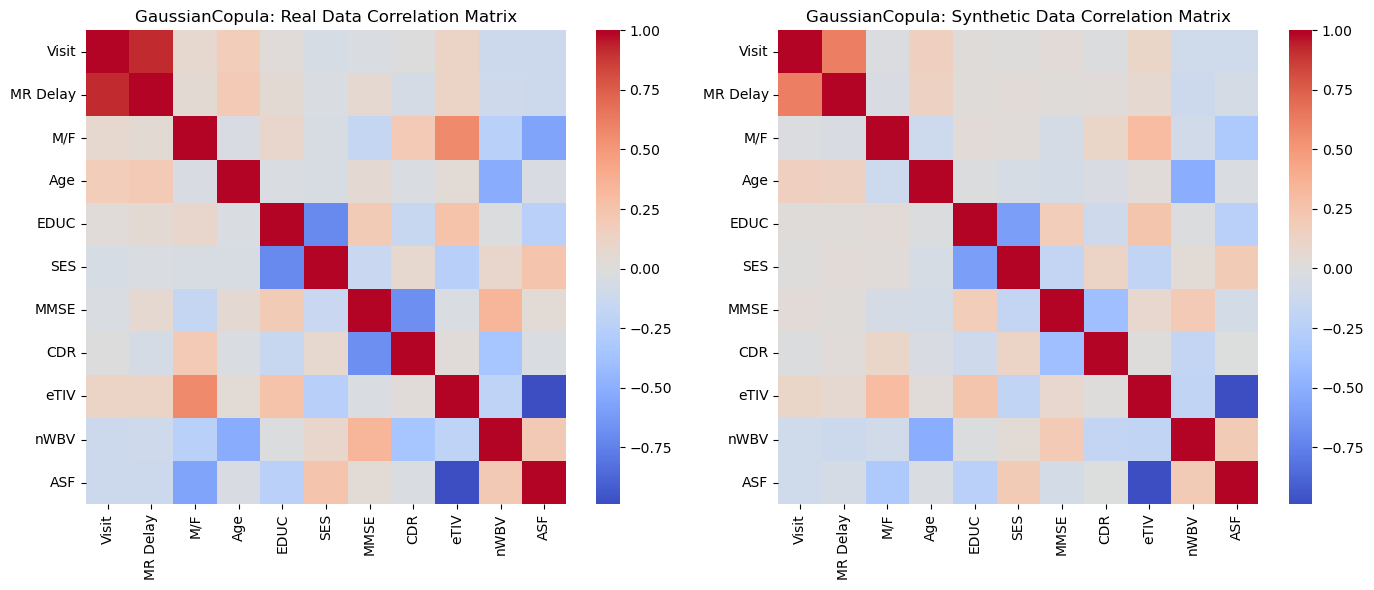

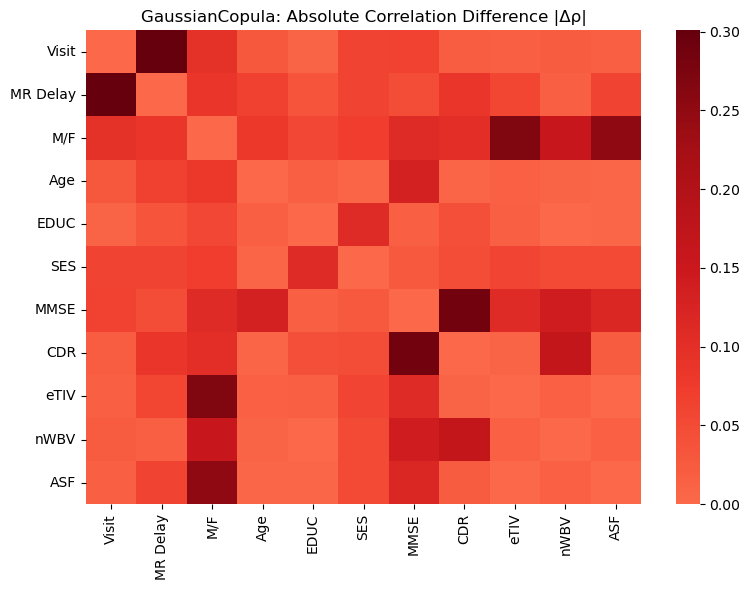

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Real dataset (cancer or AD-with-diagnosis-style target)
real_df = ad_data   # or cancer_data, etc.

# Synthetic datasets for the four models
synthetic_data_dict = {
    "CTGAN": synthetic_data["CTGAN"],
    "CopulaGAN": synthetic_data["CopulaGAN"],
    "TVAE": synthetic_data["TVAE"],
    "GaussianCopula": synthetic_data["GaussianCopula"]
}

target_col = "Group"   # change to "Group" if using AD data

# numeric columns (exclude target)
num_cols = [c for c in real_df.columns if c != target_col]

for model_name, synth_df in synthetic_data_dict.items():
    # Align columns
    synth_aligned = synth_df[real_df.columns]

    # ---- 1) Real vs Synthetic correlation matrices ----
    real_corr = real_df[num_cols].corr()
    synth_corr = synth_aligned[num_cols].corr()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(real_corr, cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title(f"{model_name}: Real Data Correlation Matrix")

    sns.heatmap(synth_corr, cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title(f"{model_name}: Synthetic Data Correlation Matrix")

    plt.tight_layout()
    plt.show()

    # ---- 2) Absolute correlation difference |Δρ| ----
    diff_corr = (real_corr - synth_corr).abs()

    plt.figure(figsize=(8, 6))
    sns.heatmap(diff_corr, cmap="Reds", center=0)
    plt.title(f"{model_name}: Absolute Correlation Difference |Δρ|")
    plt.tight_layout()
    plt.show()


CTGAN (AD) - Multivariate Evaluation
CTGAN (AD) - Global MMD (RBF): 0.0048


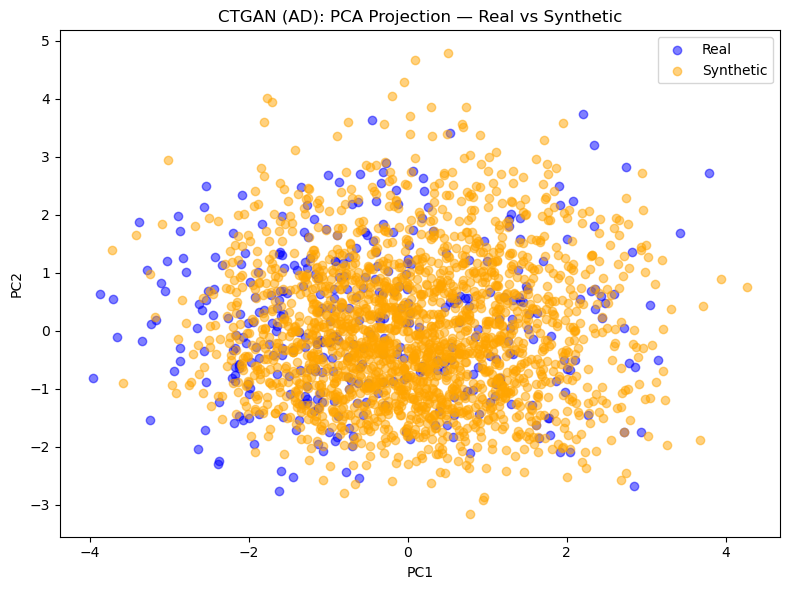

CTGAN (AD) - Two-Sample Classifier Accuracy: 0.9565

CopulaGAN (AD) - Multivariate Evaluation
CopulaGAN (AD) - Global MMD (RBF): 0.0047


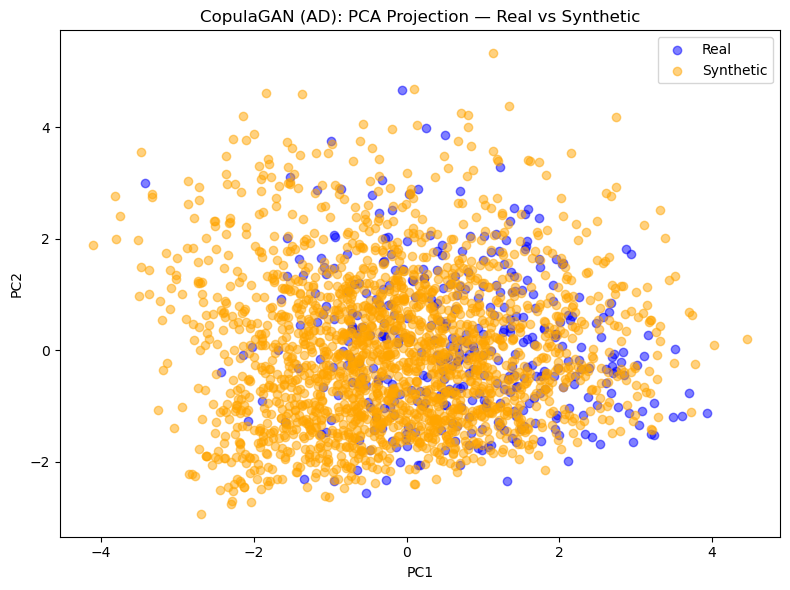

CopulaGAN (AD) - Two-Sample Classifier Accuracy: 0.9747

TVAE (AD) - Multivariate Evaluation
TVAE (AD) - Global MMD (RBF): 0.0065


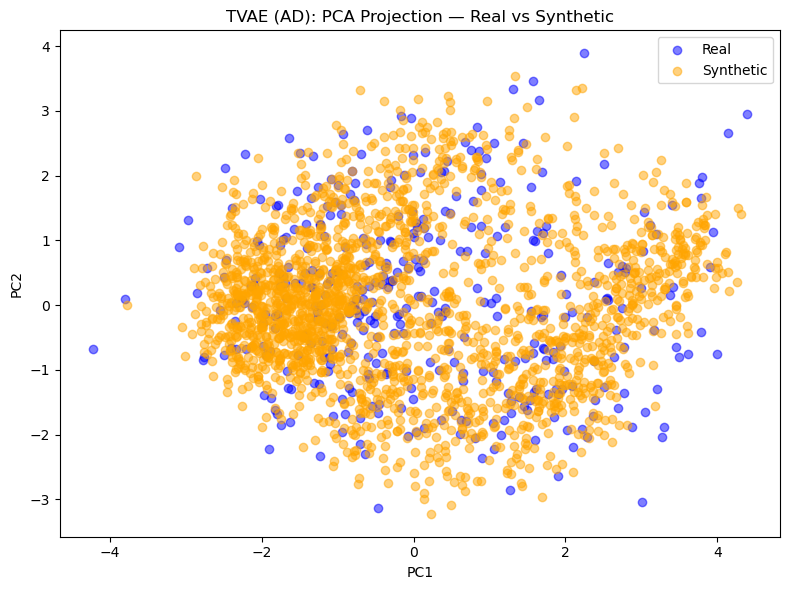

TVAE (AD) - Two-Sample Classifier Accuracy: 0.9663

GaussianCopula (AD) - Multivariate Evaluation
GaussianCopula (AD) - Global MMD (RBF): 0.0063


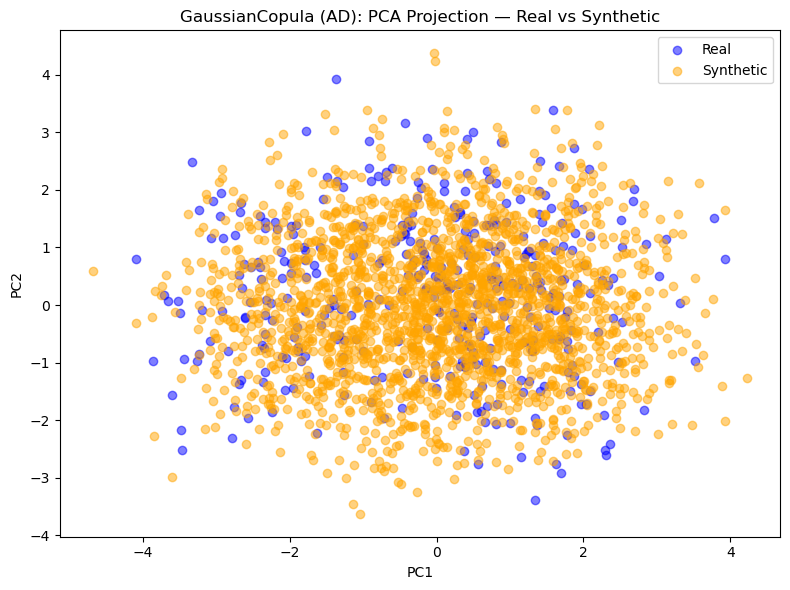

GaussianCopula (AD) - Two-Sample Classifier Accuracy: 0.9902


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import matplotlib.pyplot as plt

# --- MMD function (as you defined) ---
def mmd_rbf(X, Y, gamma=1.0):
    K_xx = rbf_kernel(X, X, gamma=gamma).mean()
    K_yy = rbf_kernel(Y, Y, gamma=gamma).mean()
    K_xy = rbf_kernel(X, Y, gamma=gamma).mean()
    return K_xx + K_yy - 2 * K_xy

# List / order of models to evaluate
model_names = ["CTGAN", "CopulaGAN", "TVAE", "GaussianCopula"]

for model_name in model_names:
    print("\n" + "="*60)
    print(f"{model_name} (AD) - Multivariate Evaluation")
    print("="*60)

    # ----- 1. Global MMD (RBF) -----
    scaler_mmd = StandardScaler()

    X_real = scaler_mmd.fit_transform(
        ad_data.drop(columns=['Group'])
    )
    X_synth = scaler_mmd.transform(
        synthetic_data[model_name].drop(columns=['Group'])
    )

    mmd_value = mmd_rbf(X_real, X_synth)
    print(f"{model_name} (AD) - Global MMD (RBF): {mmd_value:.4f}")

    # ----- 2. PCA visualization: Real vs Synthetic -----
    pca = PCA(n_components=2)
    X_all = np.vstack([X_real, X_synth])

    labels = np.array(
        ['Real'] * len(X_real) +
        ['Synthetic'] * len(X_synth)
    )

    X_pca = pca.fit_transform(X_all)

    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_pca[labels == 'Real', 0],
        X_pca[labels == 'Real', 1],
        color='blue', alpha=0.5, label='Real'
    )
    plt.scatter(
        X_pca[labels == 'Synthetic', 0],
        X_pca[labels == 'Synthetic', 1],
        color='orange', alpha=0.5, label='Synthetic'
    )
    plt.title(f"{model_name} (AD): PCA Projection — Real vs Synthetic")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----- 3. Classifier Two-Sample Test -----
    y_real = np.ones(len(X_real))
    y_synth = np.zeros(len(X_synth))

    X_all_clf = np.vstack([X_real, X_synth])
    y_all_clf = np.hstack([y_real, y_synth])

    X_train, X_test, y_train, y_test = train_test_split(
        X_all_clf,
        y_all_clf,
        test_size=0.3,
        stratify=y_all_clf,
        random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"{model_name} (AD) - Two-Sample Classifier Accuracy: {acc:.4f}")
